## 0 - Unzip Test Dataset

In [ ]:
from zipfile import ZipFile

# Define the path to your zip file
zip_path = "/content/TestDataSet.zip"

# Unzip the file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/TestDataSet")

print("Unzipped successfully.")

Unzipped successfully.


# Project 3 - Team Members:


1.   Alper Mumcular - am14533
2.   Rahil Singhi - rs9174
3.   Divya Srinivasan - ds7852



**Dependencies**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
from tqdm import tqdm


## Task 1: Basics

In [ ]:
# Define the mean and standard deviation for normalization (commonly used for ImageNet-pretrained models)
mean_norms = np.array([0.485, 0.456, 0.406])  # Mean values for each RGB channel
std_norms = np.array([0.229, 0.224, 0.225])   # Standard deviation values for each RGB channel

# Compose a sequence of image transformations
plain_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert a PIL Image or NumPy ndarray to a PyTorch tensor (scales pixel values to [0, 1])
    transforms.Normalize(mean=mean_norms, std=std_norms)  # Normalize each channel using the specified mean and std
])

We need to define a wrapper class for dataset, to handle images labeled between 401 and 500.

In [ ]:
# A wrapper class for an existing dataset to modify the labels
class WrapperDataset(Dataset):
    def __init__(self, base_dataset):
        """
        Initialize the WrapperDataset with a base dataset.

        Args:
            base_dataset (Dataset): The original dataset to wrap and modify.
        """
        self.base = base_dataset

    def __getitem__(self, idx):
        """
        Retrieve an item from the base dataset and modify its label.

        Args:
            idx (int): Index of the data item.

        Returns:
            tuple: (image, modified_label) where modified_label = original_label + 401
        """
        img, label = self.base[idx]
        return img, label + 401  # Offset the original label by 401

    def __len__(self):
        """
        Return the total number of items in the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.base)

In [ ]:
# Path to the dataset directory (structured with subfolders per class)
dataset_path = "./TestDataSet/TestDataSet"

# Load the image dataset from the directory using ImageFolder and apply transforms
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

# Wrap the dataset using the custom WrapperDataset to shift labels (e.g., for class ID offset)
dataset = WrapperDataset(dataset)

# Set the computation device to GPU if available
device = torch.device("cuda")

# Load a pretrained ResNet-34 model with ImageNet weights and move it to the specified device
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s]


### Util Functions

In [ ]:
def visualize_misclassified_cases(model, original_dataset, adversarial_dataset, class_names=None, num_cases=5):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    misclassified = []  # List to store misclassified examples

    # Convert normalization stats to tensors and reshape for broadcasting
    mean = torch.tensor(mean_norms).view(3, 1, 1)
    std = torch.tensor(std_norms).view(3, 1, 1)

    # Shuffle dataset indices for randomness
    indices = list(range(len(original_dataset)))
    random.shuffle(indices)

    # Loop through the dataset
    for i in indices:
        orig_img, label = original_dataset[i]      # Get original image and label
        adv_img, _ = adversarial_dataset[i]        # Get adversarial image (same label is assumed)

        # Add batch dimension and move to device
        orig_input = orig_img.unsqueeze(0).to(device)
        adv_input = adv_img.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        # Get predictions (no gradient computation)
        with torch.no_grad():
            orig_probs = F.softmax(model(orig_input), dim=1)  # Probabilities for original image
            adv_probs = F.softmax(model(adv_input), dim=1)    # Probabilities for adversarial image

        # Get predicted class labels
        orig_top1 = orig_probs.argmax(dim=1)
        adv_top1 = adv_probs.argmax(dim=1)

        # Select misclassified adversarial examples that were correctly classified before
        if adv_top1.item() != label.item() and 401 <= label.item() <= 500 and orig_top1 == label.item():
            misclassified.append((orig_img, adv_img, label.item(), orig_probs.squeeze(), adv_probs.squeeze()))
            if len(misclassified) >= num_cases:
                break  # Stop when enough cases are collected

    # Visualization of misclassified examples
    for idx, (orig_img, adv_img, label, orig_probs, adv_probs) in enumerate(misclassified):
        fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # Create a row of 6 subplots

        noise = adv_img - orig_img  # Calculate adversarial perturbation

        # Unnormalize the images for display (reverse of normalization)
        orig_img_show = torch.clamp(orig_img * std + mean, 0, 1).permute(1, 2, 0).cpu().numpy()
        adv_img_show = torch.clamp(adv_img * std + mean, 0, 1).permute(1, 2, 0).cpu().numpy()
        noise_show = (noise.permute(1, 2, 0).cpu().numpy() + 0.5)  # Shift noise for visibility
        noise_show = np.clip(noise_show, 0, 1)

        # Show original image
        axes[0].imshow(orig_img_show)
        axes[0].set_title(f"Original\n(True: {class_names[label] if class_names else label})")
        axes[0].axis("off")

        # Show adversarial image
        axes[1].imshow(adv_img_show)
        adv_pred = adv_probs.argmax().item()
        axes[1].set_title(f"Adversarial\n(Wrong: {class_names[adv_pred] if class_names else adv_pred})")
        axes[1].axis("off")

        # Show perturbation (noise)
        axes[2].imshow(noise_show)
        axes[2].set_title("Perturbation")
        axes[2].axis("off")

        # Plot top-5 predictions for original image
        top5_orig_probs, top5_orig_classes = torch.topk(orig_probs, 5)
        axes[3].barh(range(5), top5_orig_probs.cpu().numpy())
        axes[3].set_yticks(range(5))
        axes[3].set_yticklabels([
            class_names[i] if class_names else f"Class {i}" for i in top5_orig_classes.cpu().numpy()
        ])
        axes[3].invert_yaxis()
        axes[3].set_title("Top-5 Original")

        # Plot top-5 predictions for adversarial image
        top5_adv_probs, top5_adv_classes = torch.topk(adv_probs, 5)
        axes[4].barh(range(5), top5_adv_probs.cpu().numpy(), color='orange')
        axes[4].set_yticks(range(5))
        axes[4].set_yticklabels([
            class_names[i] if class_names else f"Class {i}" for i in top5_adv_classes.cpu().numpy()
        ])
        axes[4].invert_yaxis()
        axes[4].set_title("Top-5 Adversarial")

        # Empty placeholder for layout symmetry
        axes[5].axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
def visualize_samples(original_data, adversarial_data):
    # Normalization statistics (used to reverse normalization and visualize correctly)
    mean_tensor = torch.tensor(mean_norms).reshape(3, 1, 1)
    std_tensor = torch.tensor(std_norms).reshape(3, 1, 1)

    # Randomly select 5 indices from the dataset to visualize
    selected_indices = random.sample(range(len(original_data)), 5)

    # Create a 2x5 subplot grid for displaying 5 original and 5 adversarial images
    fig, axes = plt.subplots(2, 5, figsize=(16, 6))

    # Iterate through the selected indices
    for col_idx, sample_idx in enumerate(selected_indices):
        # Retrieve original image and its label (label is unused)
        original_image, _ = original_data[sample_idx]
        # Denormalize the original image for visualization (clamp to [0, 1] to ensure valid pixel values)
        denormalized_original = torch.clamp(original_image * std_tensor + mean_tensor, 0, 1)

        # Retrieve adversarial image and its label (label is unused)
        adversarial_image, _ = adversarial_data[sample_idx]
        # Denormalize the adversarial image
        denormalized_adversarial = torch.clamp(adversarial_image * std_tensor + mean_tensor, 0, 1)

        # Display the original image in the top row
        axes[0, col_idx].imshow(denormalized_original.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        axes[0, col_idx].set_title("Original Image")
        axes[0, col_idx].set_axis_off()  # Hide axis ticks

        # Display the adversarial image in the bottom row
        axes[1, col_idx].imshow(denormalized_adversarial.permute(1, 2, 0))
        axes[1, col_idx].set_title("Adversarial Image")
        axes[1, col_idx].set_axis_off()

    # Show the complete plot with all selected images
    plt.show()


In [ ]:
def check_linf_distance(org_dataset, adversarial_dataset):
    # List to store the L∞ (Linfinity) distances for each image pair
    linf_distances = []

    # Iterate through each image in the datasets
    for i in range(len(org_dataset)):
        # Retrieve the original image and its label (label is not used here)
        orig_img, _ = org_dataset[i]
        # Retrieve the adversarial image and its label (label is not used here)
        adv_img, _ = adversarial_dataset[i]

        # Compute the absolute difference between the original and adversarial images
        diff = torch.abs(orig_img - adv_img)

        # Find the maximum value of the absolute difference (L∞ distance for the image)
        linf_distances.append(diff.max().item())

    # Return the maximum L∞ distance from the list
    max_linf = max(linf_distances)
    return max_linf


In [ ]:
def evaluate(pretrained_model, dataset):
    # Set the model to evaluation mode (turn off dropout, batchnorm, etc.)
    pretrained_model.eval()

    # Create a DataLoader for batching the dataset during evaluation
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Initialize counters for correct predictions and total samples
    top1_correct = top5_correct = total = 0

    # Disable gradient calculations for evaluation (saves memory and computations)
    with torch.no_grad():
        # Iterate over batches of images and labels from the dataloader
        for images, labels in dataloader:
            # Move images and labels to the appropriate device (GPU/CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Get the model's predictions (logits) for the current batch of images
            outputs = pretrained_model(images)

            # Apply softmax to the outputs to get probabilities for each class
            probs = softmax(outputs, dim=1)

            # Get the top 5 predicted class indices for each image
            _, top5 = probs.topk(5, dim=1)

            # The top-1 prediction is the first element in the top5 list
            top1 = top5[:, 0]
            # Increment the correct top-1 count if the top-1 prediction matches the true label
            top1_correct += (top1 == labels).sum().item()

            # Count how many times the correct label is among the top 5 predictions
            for i, label in enumerate(labels):
                if label in top5[i]:
                    top5_correct += 1

            # Keep track of the total number of samples processed
            total += labels.size(0)

    # Calculate the top-1 accuracy (percentage of samples where the correct label is the top-1 prediction)
    top1_accuracy = 100 * top1_correct / total
    # Calculate the top-5 accuracy (percentage of samples where the correct label is among the top 5 predictions)
    top5_accuracy = 100 * top5_correct / total

    # Return both top-1 and top-5 accuracies
    return top1_accuracy, top5_accuracy


In [ ]:
def run(attack_func, attack_func_args={}):
    # Start the timer to measure the total runtime of the attack process
    start_time = time.time()

    # Lists to store the generated adversarial images and their corresponding true labels
    generated_images = []
    true_targets = []

    # Iterate over the entire dataset to apply the attack
    for index in tqdm(range(len(dataset))):
        # Get the original image and its true label from the dataset
        input_image, target_label = dataset[index]

        # Add an extra dimension to the input image to make it a batch (for model compatibility)
        input_batch = input_image.unsqueeze(0)

        # Convert the label to a tensor
        target_tensor = torch.tensor([target_label])

        # Apply the attack function to generate the perturbed image
        perturbed_image = attack_func(pretrained_model, input_batch, target_tensor, **attack_func_args)

        # Remove the batch dimension, detach from the computation graph, and move it to the CPU
        processed_image = perturbed_image.squeeze(0).detach().cpu()

        # Store the perturbed image and the true label
        generated_images.append(processed_image)
        true_targets.append(target_label)

    # Convert the list of generated images and labels to tensors
    images_tensor = torch.stack(generated_images)
    labels_tensor = torch.tensor(true_targets)

    # Create a TensorDataset with the generated adversarial images and true labels
    adv_data_loader = TensorDataset(images_tensor, labels_tensor)

    # Evaluate the model's performance on the adversarial examples
    top1_accuracy, top5_accuracy = evaluate(pretrained_model, adv_data_loader)

    # Print the accuracy results and compare with the baseline accuracy
    print(f'Top 1 Accuracy: {top1_accuracy:.1f}% (Baseline Difference: {top1_accuracy_baseline - top1_accuracy:.1f}%)')
    print(f'Top 5 Accuracy: {top5_accuracy:.1f}% (Baseline Difference: {top5_accuracy_baseline - top5_accuracy:.1f}%)')

    # Calculate and print the maximum L∞ distance between the original and adversarial images
    max_linf = check_linf_distance(dataset, adv_data_loader)
    print(f"Max L∞ distance over dataset: {max_linf:.2f}")

    # End the timer and print the total runtime
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Total runtime: {runtime:.2f} seconds")

    # Return the adversarial data loader containing the generated adversarial examples
    return adv_data_loader


**Baseline Accuracies**

In [ ]:
# Evaluate the model's performance on the original dataset to establish baseline top-1 and top-5 accuracies
top1_accuracy_baseline, top5_accuracy_baseline = evaluate(pretrained_model, dataset)

# Show baseline results
print(f'Top 1 Accuracy: {top1_accuracy_baseline:.1f}% - Baseline')
print(f'Top 5 Accuracy: {top5_accuracy_baseline:.1f}% - Baseline')

Top 1 Accuracy: 76.0% - Baseline
Top 5 Accuracy: 94.2% - Baseline


## Task 2:  Pixel-wise attacks

In [ ]:
def fgsm(model, image, label, e=0.02):
    # Set the model to evaluation mode and move it to the appropriate device (GPU/CPU)
    model.eval().to(device)

    # Clone the input image, move it to the device, and set it to require gradients for backpropagation
    image = image.clone().to(device).detach().requires_grad_(True)

    # Move the label to the appropriate device
    label = label.to(device)

    # Perform a forward pass: compute the model's output for the input image
    output = model(image)

    # Compute the loss using cross-entropy (standard loss for classification)
    loss = cross_entropy(output, label)

    # Zero the gradients of the model to avoid accumulation from previous steps
    model.zero_grad()

    # Backpropagate the loss to compute gradients with respect to the input image
    loss.backward()

    # Generate the adversarial image by applying the sign of the gradient to the input image
    adv_image = image + e * image.grad.sign()

    # Return the adversarial image with gradients detached (no further backpropagation)
    return adv_image.detach()


In [ ]:
# Generate adversarial examples using the FGSM attack with an epsilon value of 0.02 and evaluate the model's performance on the perturbed images
adversarial_test_set_1 = run(attack_func=fgsm, attack_func_args={"e": 0.02})

100%|██████████| 500/500 [00:08<00:00, 56.45it/s]


Top 1 Accuracy: 6.0% (Baseline Difference: 70.0%)
Top 5 Accuracy: 35.6% (Baseline Difference: 58.6%)
Max L∞ distance over dataset: 0.02
Total runtime: 9.77 seconds


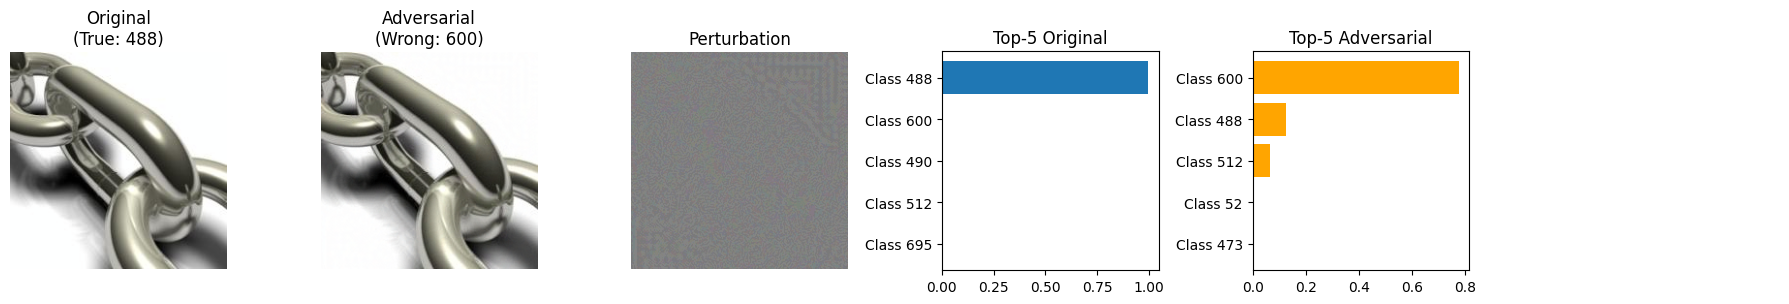

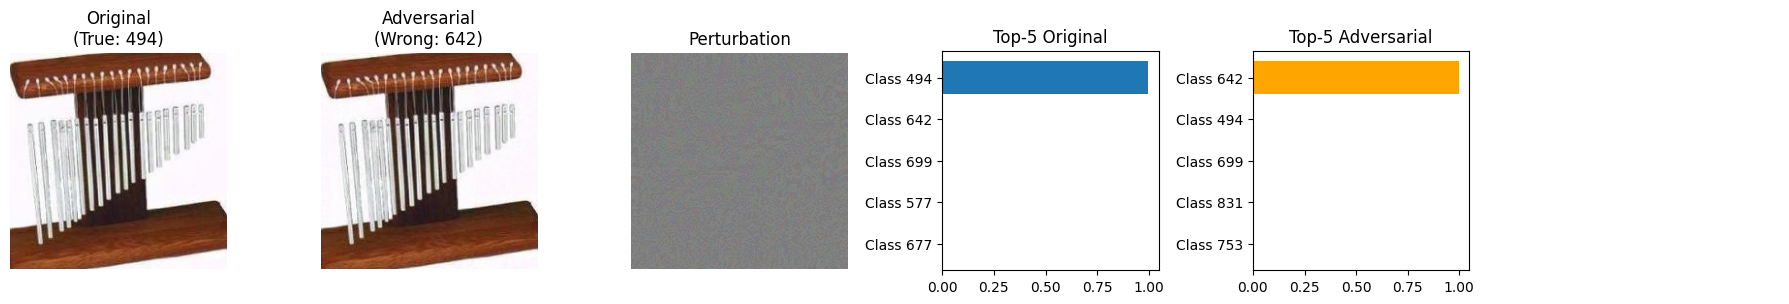

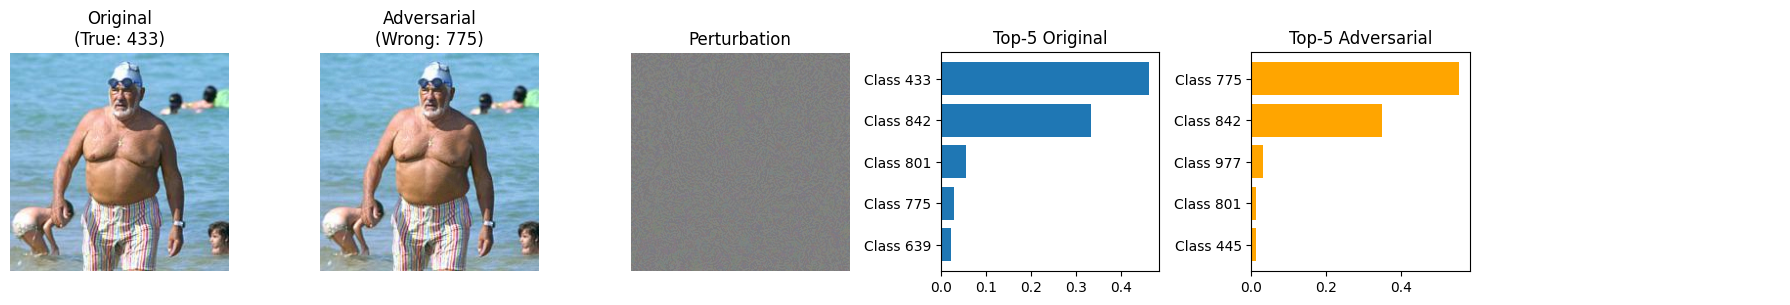

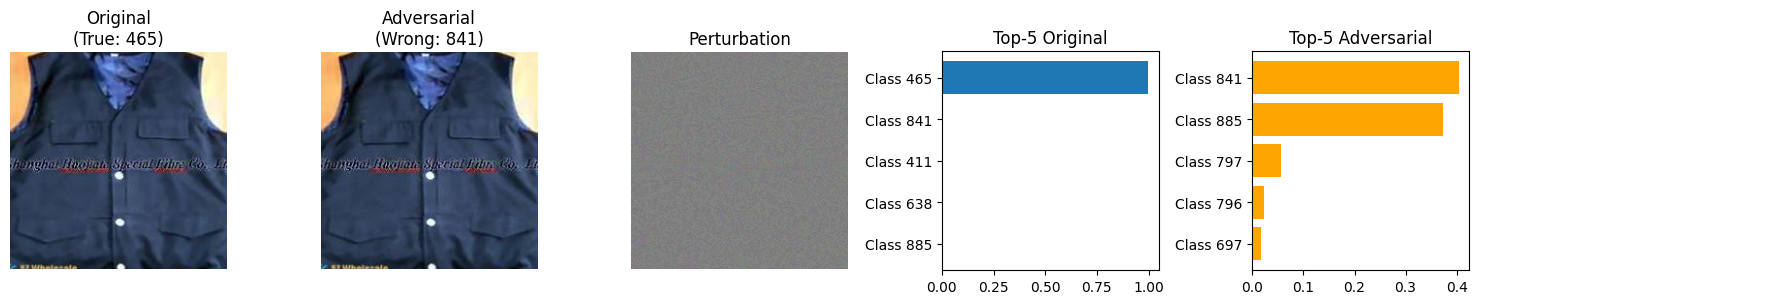

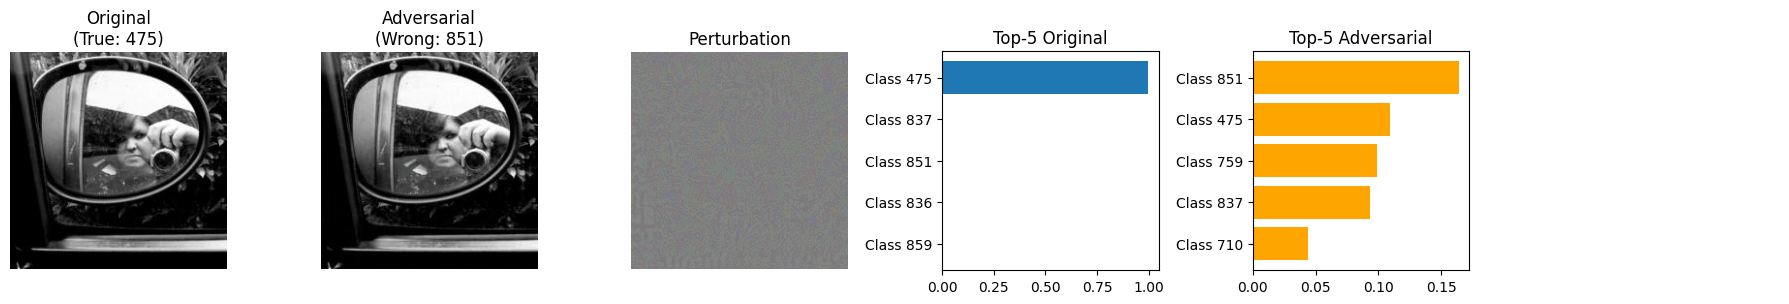

In [ ]:
# Visualize and display a few misclassified cases from the adversarial test set by comparing the model's predictions on the original dataset and adversarial examples
visualize_misclassified_cases(pretrained_model, dataset, adversarial_test_set_1, num_cases=5)

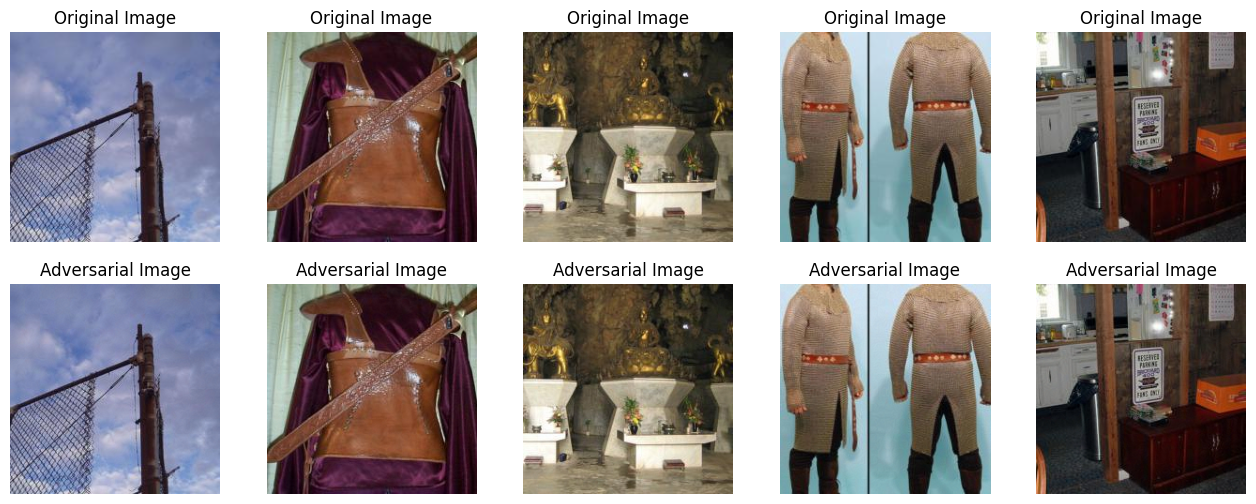

In [ ]:
# Visualize a selection of original and adversarial images from the dataset to compare the effects of the adversarial attack
visualize_samples(dataset, adversarial_test_set_1)

## Task 3: Improved attacks

**Iterative FGSM**

In [ ]:
def iterative_fgsm(model, image, label, e=0.02, alpha=0.002, iters=10):
    """
    Iterative FGSM (BIM) with strict L∞ constraint (max perturbation <= e).
    This method applies a multi-step version of the FGSM attack, iterating the attack process
    to generate stronger adversarial examples while keeping the perturbation bounded by a maximum value of e.
    """
    # Get the device (GPU/CPU) the model is using
    device = next(model.parameters()).device

    # Move image and label to the correct device (GPU/CPU)
    image = image.to(device)
    label = label.to(device)

    # Set model to evaluation mode
    model.eval()

    # Clone the original image to preserve it for later reference (for L∞ constraint)
    ori_image = image.clone().detach()

    # Initialize the image for the attack (requires gradients for backpropagation)
    image = ori_image.clone().detach().requires_grad_(True)

    # Perform iterative attack for 'iters' steps
    for _ in range(iters):
        # Forward pass through the model
        output = model(image)

        # Compute the loss using cross-entropy
        loss = nn.functional.cross_entropy(output, label)

        # Zero the gradients from the previous step
        model.zero_grad()

        # Backpropagate the loss to get gradients with respect to the input image
        loss.backward()

        # Update the image by adding the gradient's sign to the image (perturbation)
        image = image + alpha * image.grad.sign()

        # Ensure the perturbation stays within the L∞ constraint (max perturbation <= e)
        image = torch.clamp(image, ori_image - e, ori_image + e)

        # Detach the image to avoid gradients from accumulating, and re-enable gradient tracking
        image = image.detach().requires_grad_(True)

    # Return the adversarial image with gradients detached
    return image.detach()


{'e': 0.02, 'alpha': 0.008, 'iters': 10} best among different alpha values

In [ ]:
# Define a set of configurations for the iterative FGSM attack, varying the 'alpha' parameter
configurations = [
    {"e": 0.02, "alpha": 0.002, "iters": 10},
    {"e": 0.02, "alpha": 0.004, "iters": 10},
    {"e": 0.02, "alpha": 0.006, "iters": 10},
    {"e": 0.02, "alpha": 0.008, "iters": 10},
    {"e": 0.02, "alpha": 0.01, "iters": 10},
    {"e": 0.02, "alpha": 0.012, "iters": 10},
    {"e": 0.02, "alpha": 0.014, "iters": 10}
]

# Iterate through the different configurations of the attack
for config in configurations:
    print("\n" + str(config))  # Print the current configuration being tested
    # Run the attack using the current configuration and evaluate its effectiveness
    run(attack_func=iterative_fgsm, attack_func_args=config)



{'e': 0.02, 'alpha': 0.002, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.55it/s]


Top 1 Accuracy: 0.2% (Baseline Difference: 75.8%)
Top 5 Accuracy: 14.0% (Baseline Difference: 80.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.09 seconds

{'e': 0.02, 'alpha': 0.004, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.54it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.8% (Baseline Difference: 83.4%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.28 seconds

{'e': 0.02, 'alpha': 0.006, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.0% (Baseline Difference: 84.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.38 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.4% (Baseline Difference: 83.8%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.37 seconds

{'e': 0.02, 'alpha': 0.01, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.53it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.2% (Baseline Difference: 84.0%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.35 seconds

{'e': 0.02, 'alpha': 0.012, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.6% (Baseline Difference: 83.6%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.35 seconds

{'e': 0.02, 'alpha': 0.014, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 13.4% (Baseline Difference: 80.8%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.37 seconds


{'e': 0.02, 'alpha': 0.008, 'iters': 25} best among different iter values

In [ ]:
# Define configurations for iterative FGSM attack with varying 'iters' parameter
configurations = [
    {'e': 0.02, 'alpha': 0.008, 'iters': 5},    # 5 iterations
    {'e': 0.02, 'alpha': 0.008, 'iters': 10},   # 10 iterations
    {'e': 0.02, 'alpha': 0.008, 'iters': 15},   # 15 iterations
    {'e': 0.02, 'alpha': 0.008, 'iters': 20},   # 20 iterations
    {'e': 0.02, 'alpha': 0.008, 'iters': 25}    # 25 iterations
]

# Iterate through each configuration to test the iterative FGSM attack with different 'iters' values
for config in configurations:
    print("\n" + str(config))  # Print the current configuration to track the experiment
    # Execute the attack with the current configuration and evaluate its impact on the model
    run(attack_func=iterative_fgsm, attack_func_args=config)



{'e': 0.02, 'alpha': 0.008, 'iters': 5}


100%|██████████| 500/500 [00:33<00:00, 14.73it/s]


Top 1 Accuracy: 0.2% (Baseline Difference: 75.8%)
Top 5 Accuracy: 13.0% (Baseline Difference: 81.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 34.82 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 10}


100%|██████████| 500/500 [01:06<00:00,  7.51it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.2% (Baseline Difference: 84.0%)
Max L∞ distance over dataset: 0.02
Total runtime: 67.45 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 15}


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 9.4% (Baseline Difference: 84.8%)
Max L∞ distance over dataset: 0.02
Total runtime: 99.69 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 20}


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 9.4% (Baseline Difference: 84.8%)
Max L∞ distance over dataset: 0.02
Total runtime: 132.09 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 25}


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 7.8% (Baseline Difference: 86.4%)
Max L∞ distance over dataset: 0.02
Total runtime: 164.52 seconds


**Projected Gradient Descent - PGD**

In [ ]:
def pgd(model, image, label, e=0.02, alpha=0.002, iters=10):
    """
    Performs the Projected Gradient Descent (PGD) attack.

    Args:
        model (torch.nn.Module): The model to attack.
        image (torch.Tensor): The input image. Shape (N, C, H, W).
        label (torch.Tensor): The correct label for the input.
        e (float): Maximum perturbation.
        alpha (float): Step size.
        iters (int): Number of attack iterations.

    Returns:
        torch.Tensor: Adversarial image (detached from the graph).
    """
    # Ensure both the model and image are on the same device (GPU or CPU)
    device = next(model.parameters()).device
    image = image.to(device)
    label = label.to(device)

    # Clone the image and make sure gradients are enabled
    original_image = image.clone().detach()
    perturbed_image = original_image.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(perturbed_image)
        loss = F.cross_entropy(outputs, label)
        loss.backward()

        # Update the image using the gradient sign
        with torch.no_grad():
            grad_sign = perturbed_image.grad.sign()
            perturbed_image += alpha * grad_sign

            # Project the perturbation within the epsilon ball
            perturbed_image = torch.max(torch.min(perturbed_image, original_image + e), original_image - e)

        # Re-enable gradient for next iteration
        perturbed_image.requires_grad_(True)
        perturbed_image.grad = None

    return perturbed_image.detach()


{'e': 0.02, 'alpha': 0.008, 'iters': 10} best among different alpha values

In [ ]:
# Define configurations for PGD attack with varying 'alpha' values, but keeping 'e' and 'iters' constant
configurations = [
    {"e": 0.02, "alpha": 0.002, "iters": 10},   # Step size 0.002
    {"e": 0.02, "alpha": 0.004, "iters": 10},   # Step size 0.004
    {"e": 0.02, "alpha": 0.006, "iters": 10},   # Step size 0.006
    {"e": 0.02, "alpha": 0.008, "iters": 10},   # Step size 0.008
    {"e": 0.02, "alpha": 0.01, "iters": 10},    # Step size 0.01
    {"e": 0.02, "alpha": 0.012, "iters": 10},   # Step size 0.012
    {"e": 0.02, "alpha": 0.014, "iters": 10}    # Step size 0.014
]

# Iterate through each configuration to test PGD attack with different step sizes (alpha)
for config in configurations:
    print("\n" + str(config))  # Print the current configuration to track the experiment
    # Execute the PGD attack with the current configuration and evaluate its impact on the model
    run(attack_func=pgd, attack_func_args=config)



{'e': 0.02, 'alpha': 0.002, 'iters': 10}


100%|██████████| 500/500 [01:07<00:00,  7.36it/s]


Top 1 Accuracy: 0.2% (Baseline Difference: 75.8%)
Top 5 Accuracy: 13.8% (Baseline Difference: 80.4%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.82 seconds

{'e': 0.02, 'alpha': 0.004, 'iters': 10}


100%|██████████| 500/500 [01:07<00:00,  7.36it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.8% (Baseline Difference: 83.4%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.88 seconds

{'e': 0.02, 'alpha': 0.006, 'iters': 10}


100%|██████████| 500/500 [01:07<00:00,  7.36it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 9.6% (Baseline Difference: 84.6%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.84 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 10}


100%|██████████| 500/500 [01:07<00:00,  7.37it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.0% (Baseline Difference: 84.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.72 seconds

{'e': 0.02, 'alpha': 0.01, 'iters': 10}


100%|██████████| 500/500 [01:07<00:00,  7.36it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 10.0% (Baseline Difference: 84.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.80 seconds

{'e': 0.02, 'alpha': 0.012, 'iters': 10}


100%|██████████| 500/500 [01:07<00:00,  7.38it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 11.2% (Baseline Difference: 83.0%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.66 seconds

{'e': 0.02, 'alpha': 0.014, 'iters': 10}


100%|██████████| 500/500 [01:08<00:00,  7.35it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 13.2% (Baseline Difference: 81.0%)
Max L∞ distance over dataset: 0.02
Total runtime: 68.94 seconds


{'e': 0.02, 'alpha': 0.008, 'iters': 25} best among different iter values

In [ ]:
# Define different configurations for PGD attack, varying the number of iterations ('iters'),
# while keeping the perturbation ('e') and step size ('alpha') constant
configurations = [
    {"e": 0.02, "alpha": 0.008, "iters": 5},   # 5 iterations
    {"e": 0.02, "alpha": 0.008, "iters": 10},  # 10 iterations
    {"e": 0.02, "alpha": 0.008, "iters": 15},  # 15 iterations
    {"e": 0.02, "alpha": 0.008, "iters": 20},  # 20 iterations
    {"e": 0.02, "alpha": 0.008, "iters": 25}   # 25 iterations
]

# Loop through each configuration and run the PGD attack
for config in configurations:
    print("\n" + str(config))  # Print the current configuration being tested
    # Execute the PGD attack with the given configuration (perturbation 'e', step size 'alpha', and iterations 'iters')
    run(attack_func=pgd, attack_func_args=config)



{'e': 0.02, 'alpha': 0.008, 'iters': 5}


100%|██████████| 500/500 [00:34<00:00, 14.44it/s]


Top 1 Accuracy: 0.2% (Baseline Difference: 75.8%)
Top 5 Accuracy: 12.8% (Baseline Difference: 81.4%)
Max L∞ distance over dataset: 0.02
Total runtime: 35.52 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 10}


100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 9.6% (Baseline Difference: 84.6%)
Max L∞ distance over dataset: 0.02
Total runtime: 69.03 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 15}


100%|██████████| 500/500 [01:41<00:00,  4.92it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 9.0% (Baseline Difference: 85.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 102.55 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 20}


100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 8.8% (Baseline Difference: 85.4%)
Max L∞ distance over dataset: 0.02
Total runtime: 135.34 seconds

{'e': 0.02, 'alpha': 0.008, 'iters': 25}


100%|██████████| 500/500 [02:48<00:00,  2.98it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 8.2% (Baseline Difference: 86.0%)
Max L∞ distance over dataset: 0.02
Total runtime: 168.95 seconds


In [ ]:
# Run the PGD (Projected Gradient Descent) attack with specified parameters:
# - Maximum perturbation (e) = 0.02
# - Step size (alpha) = 0.008
# - Number of iterations (iters) = 25
# The resulting adversarial test set is stored in the adversarial_test_set_2 variable
adversarial_test_set_2 = run(attack_func=pgd, attack_func_args={"e": 0.02, "alpha": 0.008, "iters": 25})

100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Top 1 Accuracy: 0.0% (Baseline Difference: 76.0%)
Top 5 Accuracy: 8.0% (Baseline Difference: 86.2%)
Max L∞ distance over dataset: 0.02
Total runtime: 168.61 seconds


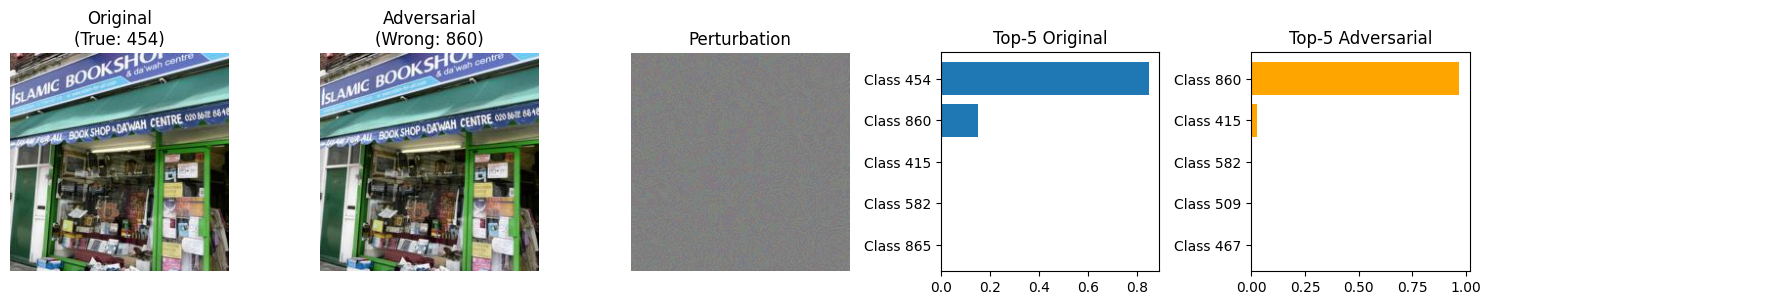

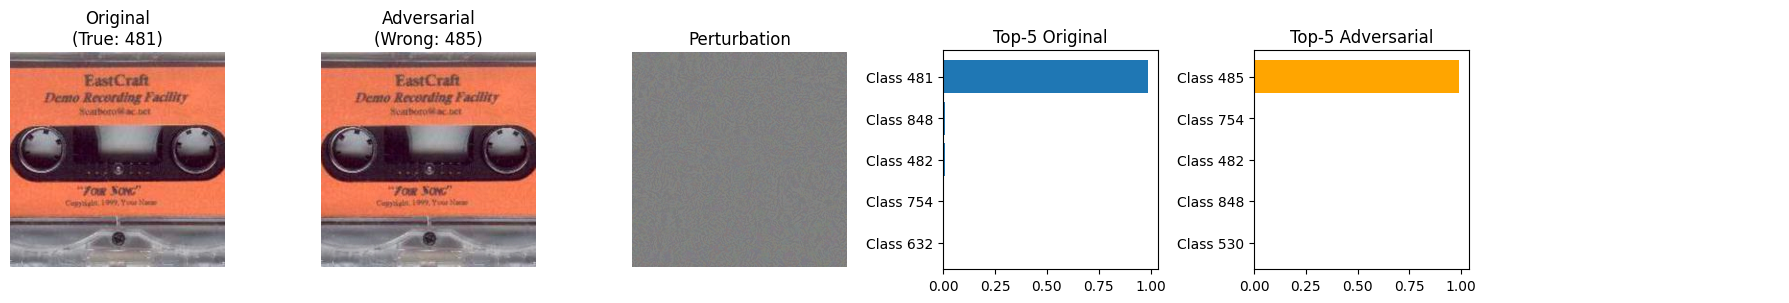

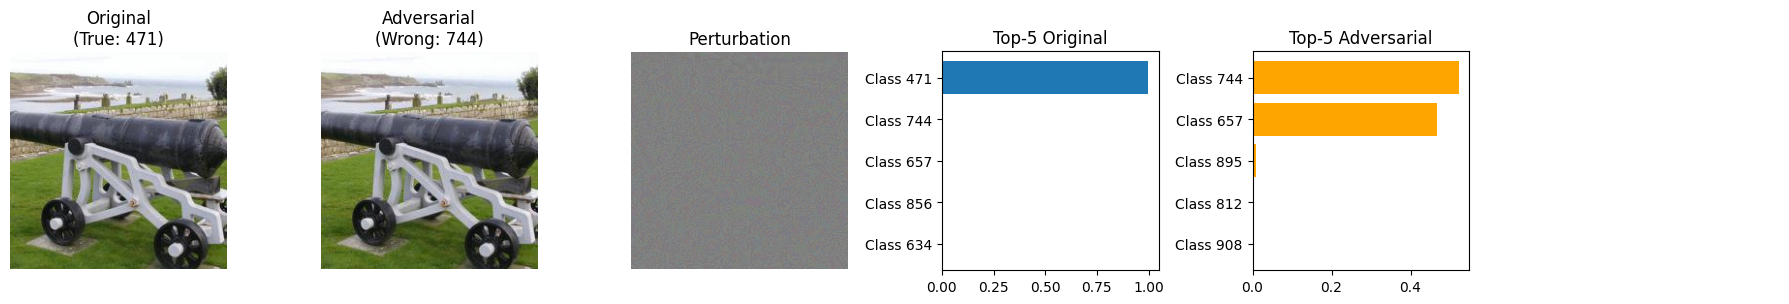

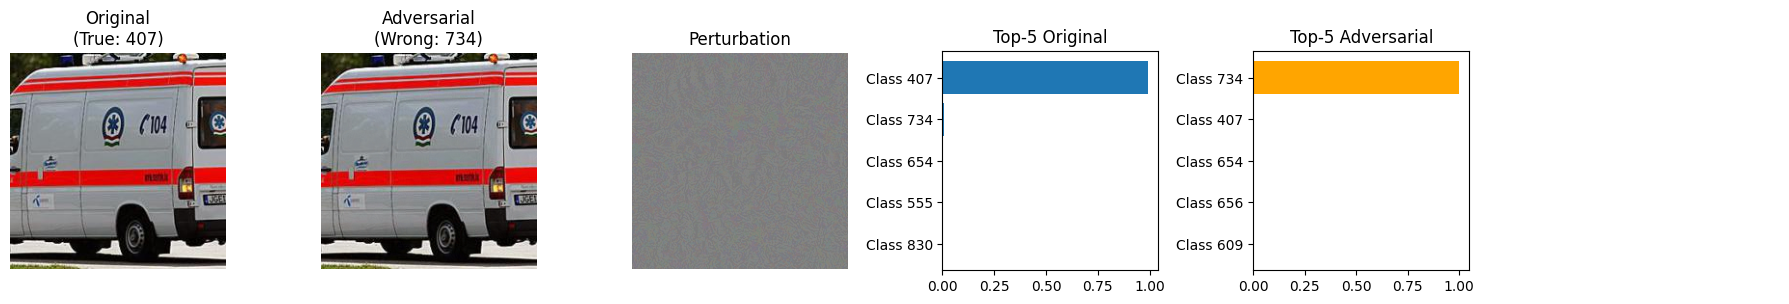

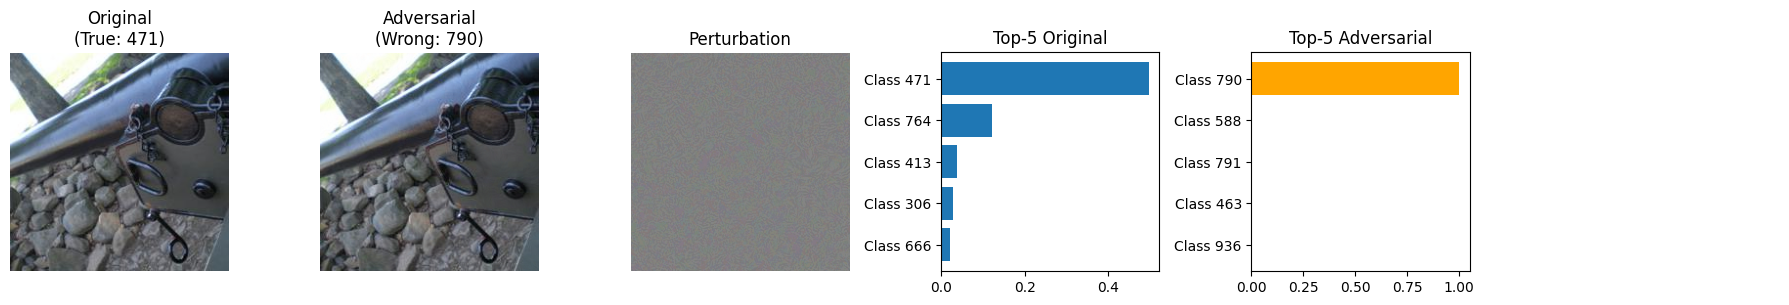

In [ ]:
# Visualize 5 misclassified cases from the adversarial test set (adversarial_test_set_2) by comparing the original and adversarial images.
visualize_misclassified_cases(pretrained_model, dataset, adversarial_test_set_2, num_cases=5)

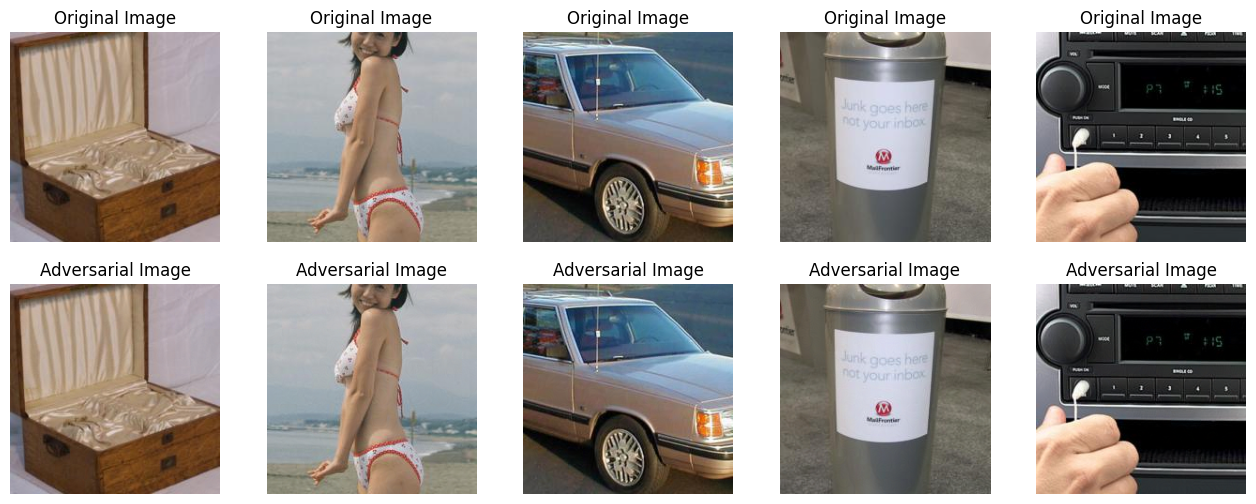

In [ ]:
# Visualize a set of samples from the original dataset and their corresponding adversarial images from the adversarial test set (adversarial_test_set_2).
visualize_samples(dataset, adversarial_test_set_2)

## Task 4: Patch attacks

#### PGD Patch

In [ ]:
def pgd_patch_attack(model, image, label, e=0.3, alpha=0.03, iters=10):
    # Set the model to evaluation mode
    model.eval()
    # Get the device from the model's parameters (CPU or GPU)
    device = next(model.parameters()).device
    image = image.to(device)
    # Create a copy of the original image to preserve the original input
    ori_image = image.clone().detach()

    # Get the image dimensions (H: height, W: width)
    _, _, H, W = image.shape
    patch_size = 32  # Define the patch size that will be attacked

    # Randomly select the top-left corner of the patch location
    x0 = random.randint(0, W - patch_size)
    y0 = random.randint(0, H - patch_size)

    # Create a mask for the patch area in the image (to attack only the patch)
    patch_mask = torch.zeros_like(image, device=device)
    patch_mask[:, :, y0:y0 + patch_size, x0:x0 + patch_size] = 1.0

    # Store the original patch to ensure the perturbation is applied to it only
    original_patch = ori_image[:, :, y0:y0 + patch_size, x0:x0 + patch_size].clone().detach()

    label = label.to(device)
    alpha_mul = 1  # Used to control the scaling of the perturbation (could be modified for varying impact)

    # Initialize the perturbed image (start with the original image)
    perturbed_image = ori_image.clone().detach()

    # Iteratively apply the perturbation using the PGD (Projected Gradient Descent) method
    for _ in range(iters):
        perturbed_image.requires_grad_(True)  # Enable gradient computation for backpropagation
        output = model(perturbed_image)  # Perform forward pass through the model

        # Compute the cross-entropy loss
        loss_value = torch.nn.functional.cross_entropy(output, label)

        model.zero_grad()  # Zero the gradients before backward pass
        loss_value.backward()  # Backpropagate the gradients

        with torch.no_grad():  # Disable gradient computation for the following operations
            grad = perturbed_image.grad  # Get the gradient of the perturbed image

            # Focus on updating only the patch area using the patch mask
            grad_patch = grad * patch_mask
            perturbation = alpha_mul * alpha * grad_patch.sign()  # Compute the perturbation based on the gradient

            # Apply the perturbation to the patch
            perturbed_image[:, :, y0:y0 + patch_size, x0:x0 + patch_size] += perturbation[:, :, y0:y0 + patch_size, x0:x0 + patch_size]

            # Project the perturbation back into the epsilon-ball (i.e., limit the perturbation magnitude)
            current_patch = perturbed_image[:, :, y0:y0 + patch_size, x0:x0 + patch_size]
            eta = torch.clamp(current_patch - original_patch, -e, e)  # Ensure the perturbation is within the bound [-e, e]
            perturbed_image[:, :, y0:y0 + patch_size, x0:x0 + patch_size] = original_patch + eta  # Apply the clipping

        perturbed_image = perturbed_image.detach()  # Detach from the computation graph after the update

    return perturbed_image  # Return the final perturbed image after the attack


#### Experiment PGD Patch Attach with different configuration

In [ ]:
# Define various attack configurations with different values for e (maximum perturbation),
# alpha (step size for each iteration), and iters (number of iterations)
configurations = [
    {"e": 0.3, "alpha": 0.0075, "iters": 20},  # First set of parameters
    {"e": 0.3, "alpha": 0.015, "iters": 20},   # Second set of parameters
    {"e": 0.4, "alpha": 0.0075, "iters": 40},  # Third set of parameters
    {"e": 0.4, "alpha": 0.015, "iters": 40},   # Fourth set of parameters
    {"e": 0.5, "alpha": 0.0075, "iters": 20},  # Fifth set of parameters
    {"e": 0.5, "alpha": 0.015, "iters": 40},   # Sixth set of parameters
    {"e": 0.5, "alpha": 0.0075, "iters": 40},  # Seventh set of parameters
    {'e': 0.4, 'alpha': 0.03, 'iters': 40},     # Eighth set of parameters
    {'e': 0.5, 'alpha': 0.03, 'iters': 40}      # Ninth set of parameters
]

# Loop through each configuration, print it, and execute the attack using the pgd_patch_attack function
for config in configurations:
    print("\n" + str(config))  # Print the current configuration for tracking
    run(attack_func=pgd_patch_attack, attack_func_args=config)  # Run the attack with the current configuration



{'e': 0.3, 'alpha': 0.0075, 'iters': 20}


100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


Top 1 Accuracy: 56.6% (Baseline Difference: 19.4%)
Top 5 Accuracy: 87.6% (Baseline Difference: 6.6%)
Max L∞ distance over dataset: 0.15
Total runtime: 134.74 seconds

{'e': 0.3, 'alpha': 0.015, 'iters': 20}


100%|██████████| 500/500 [02:13<00:00,  3.73it/s]


Top 1 Accuracy: 46.6% (Baseline Difference: 29.4%)
Top 5 Accuracy: 81.2% (Baseline Difference: 13.0%)
Max L∞ distance over dataset: 0.30
Total runtime: 134.89 seconds

{'e': 0.4, 'alpha': 0.0075, 'iters': 40}


100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Top 1 Accuracy: 43.2% (Baseline Difference: 32.8%)
Top 5 Accuracy: 80.2% (Baseline Difference: 14.0%)
Max L∞ distance over dataset: 0.30
Total runtime: 265.44 seconds

{'e': 0.4, 'alpha': 0.015, 'iters': 40}


100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Top 1 Accuracy: 37.0% (Baseline Difference: 39.0%)
Top 5 Accuracy: 75.8% (Baseline Difference: 18.4%)
Max L∞ distance over dataset: 0.40
Total runtime: 265.24 seconds

{'e': 0.5, 'alpha': 0.0075, 'iters': 20}


100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


Top 1 Accuracy: 56.2% (Baseline Difference: 19.8%)
Top 5 Accuracy: 86.8% (Baseline Difference: 7.4%)
Max L∞ distance over dataset: 0.15
Total runtime: 134.73 seconds

{'e': 0.5, 'alpha': 0.015, 'iters': 40}


100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Top 1 Accuracy: 35.0% (Baseline Difference: 41.0%)
Top 5 Accuracy: 73.2% (Baseline Difference: 21.0%)
Max L∞ distance over dataset: 0.50
Total runtime: 268.08 seconds

{'e': 0.5, 'alpha': 0.0075, 'iters': 40}


100%|██████████| 500/500 [04:25<00:00,  1.89it/s]


Top 1 Accuracy: 45.2% (Baseline Difference: 30.8%)
Top 5 Accuracy: 80.4% (Baseline Difference: 13.8%)
Max L∞ distance over dataset: 0.30
Total runtime: 266.03 seconds

{'e': 0.4, 'alpha': 0.03, 'iters': 40}


100%|██████████| 500/500 [04:29<00:00,  1.86it/s]


Top 1 Accuracy: 29.8% (Baseline Difference: 46.2%)
Top 5 Accuracy: 70.6% (Baseline Difference: 23.6%)
Max L∞ distance over dataset: 0.40
Total runtime: 270.07 seconds

{'e': 0.5, 'alpha': 0.03, 'iters': 40}


100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Top 1 Accuracy: 26.2% (Baseline Difference: 49.8%)
Top 5 Accuracy: 69.4% (Baseline Difference: 24.8%)
Max L∞ distance over dataset: 0.50
Total runtime: 265.66 seconds


In [ ]:
# Running the PGD Patch Attack with specified parameters, and get adverserial test set 3
adversarial_test_set_3 = run(attack_func=pgd_patch_attack, attack_func_args={'e': 0.5, 'alpha': 0.03, 'iters': 40})

100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


Top 1 Accuracy: 27.8% (Baseline Difference: 48.2%)
Top 5 Accuracy: 67.6% (Baseline Difference: 26.6%)
Max L∞ distance over dataset: 0.50
Total runtime: 267.21 seconds


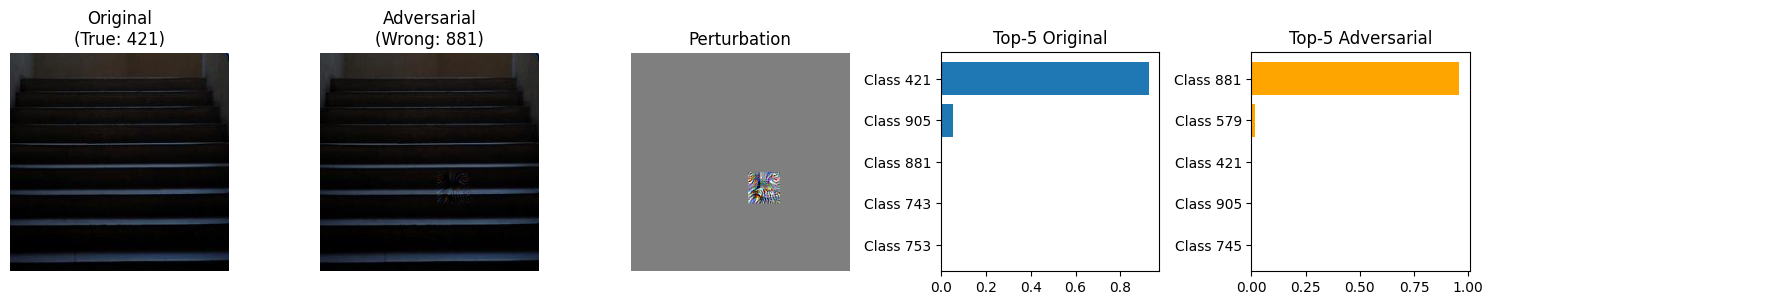

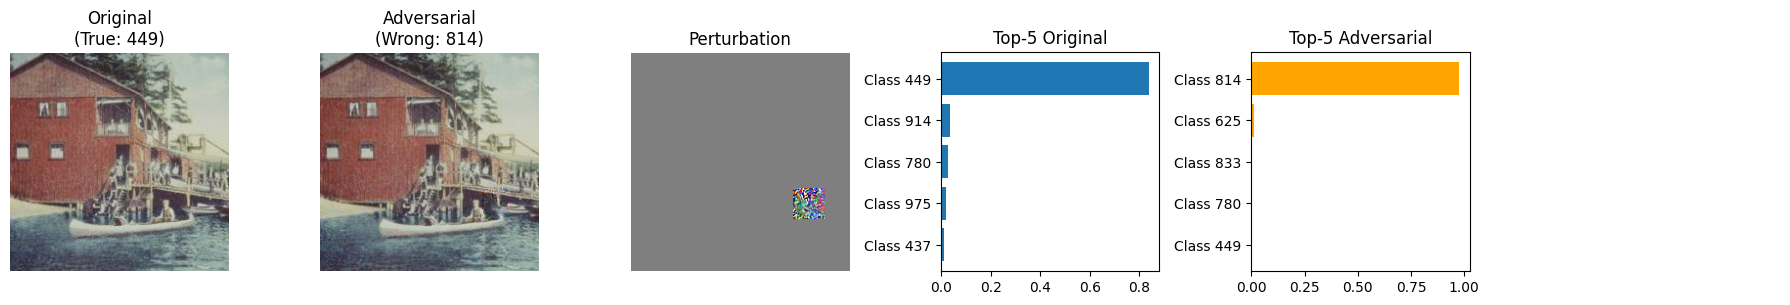

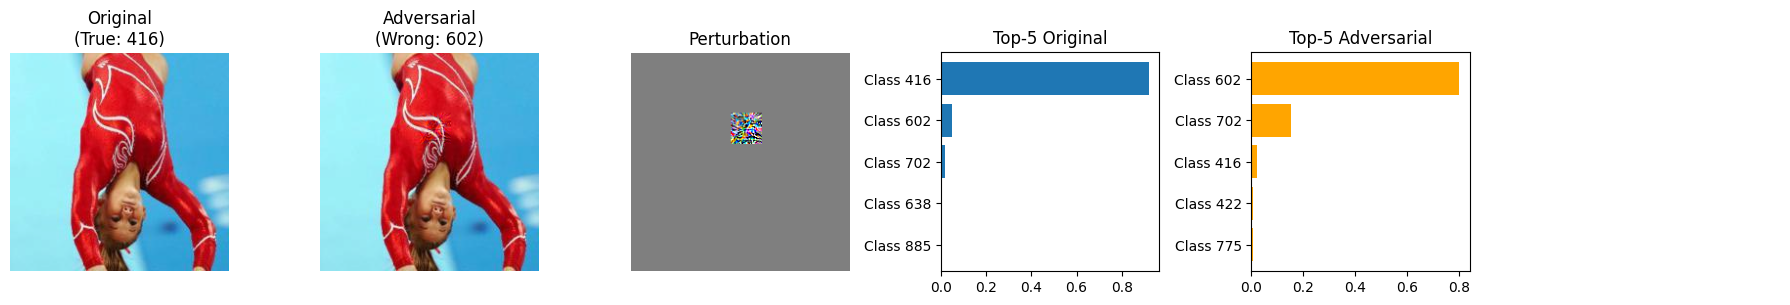

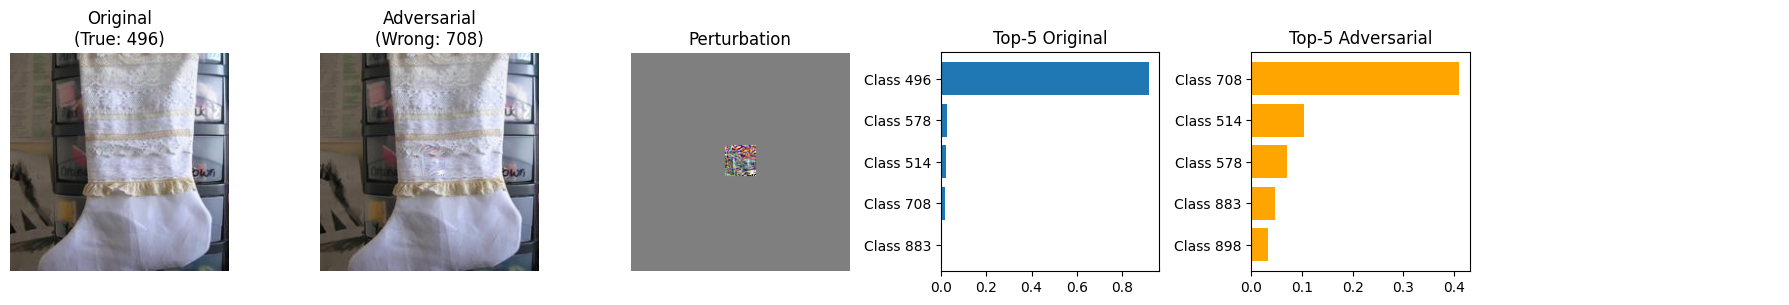

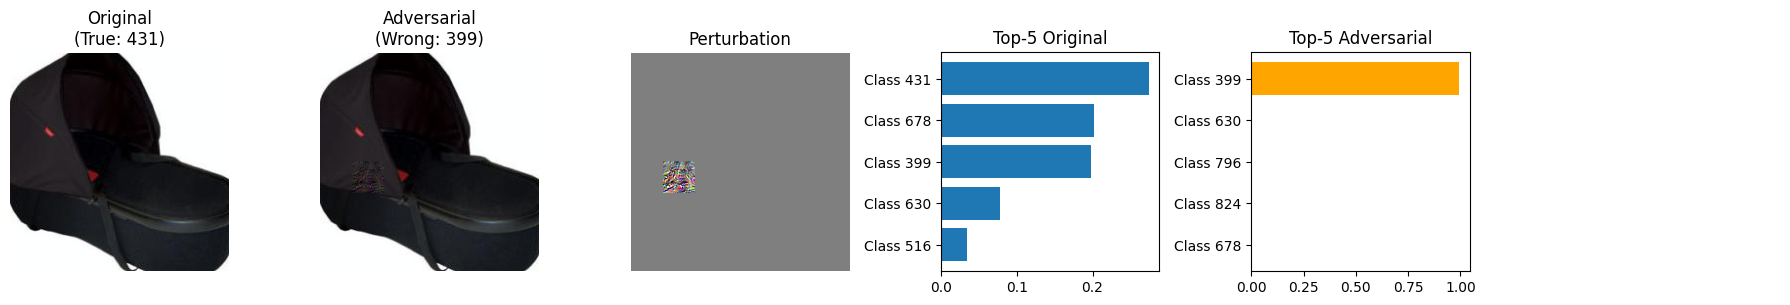

In [ ]:
# Visualizing the first 5 misclassified cases from the adversarial test set (adversarial_test_set_3),
visualize_misclassified_cases(pretrained_model, dataset, adversarial_test_set_3, num_cases=5)

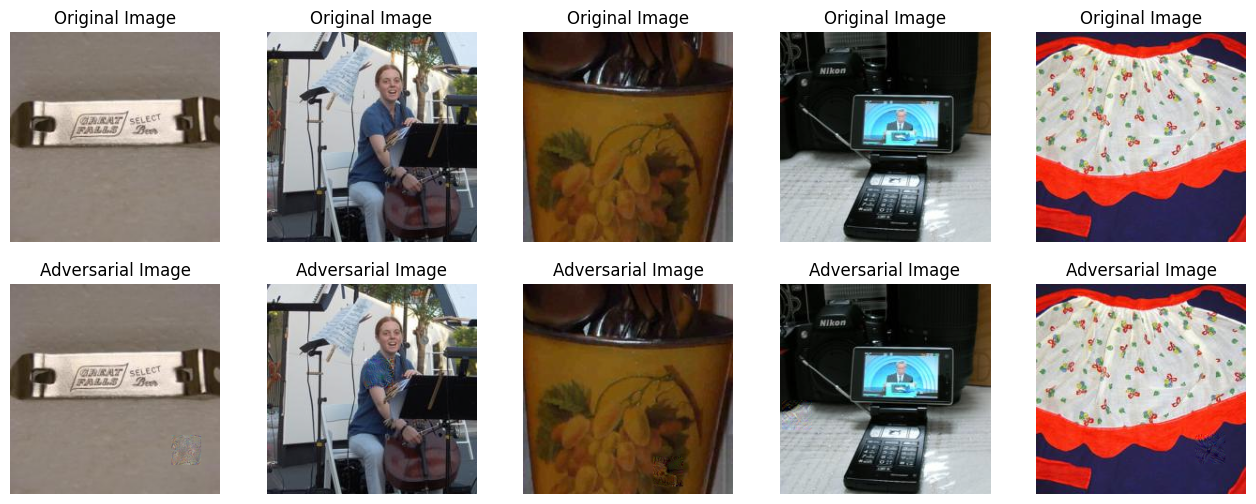

In [ ]:
# Visualizing a comparison of the original images from the dataset and adversial test set 3
visualize_samples(dataset, adversarial_test_set_3)

## Task 5: Transferring attacks

Findings, trends, lessons learned, ways to mitigate transferability is discussed in this block as well as in the report

#### Observations

DenseNet-121 demonstrated higher robustness to transferred attacks, with Top-1 accuracy ranging from **63.2% to 70.2%**. The **PGD Patch attack** showed the least transferability, likely due to its spatial localization. Differences in architecture, such as dense connectivity and gradient flow, likely contributed to reduced cross-model attack effectiveness.


### Transferability to DenseNet-121

To explore the transferability of adversarial examples, we evaluated DenseNet-121 on datasets adversarially crafted using ResNet-34. Interestingly, DenseNet-121 exhibited much higher robustness to these inputs, with Top-1 accuracy ranging from **63.2% to 70.2%** across all attack datasets. This suggests only partial transferability.

Several factors may contribute to this discrepancy:

- **Architectural Differences**: DenseNet's feature reuse and dense connectivity patterns may lead to smoother decision boundaries, making it less susceptible to perturbations crafted for other models.
- **Gradient Mismatch**: Since the attacks were generated using gradients from ResNet-34, they may not align with the loss surface of DenseNet-121, reducing effectiveness.
- **Overfitting of Attacks**: Iterative attacks in particular may overfit to the source model’s weaknesses, making them less transferable.

The **PGD Patch attack** was the least transferable, which aligns with the hypothesis that localized, high-magnitude perturbations exploit model-specific receptive fields and spatial sensitivities. This further indicates that model robustness should be evaluated not just in isolation, but also under cross-model adversarial exposure.

#### Mitigating Transferability

To mitigate the transferability of adversarial examples across models, several defense strategies can be employed:

- **Adversarial training using diverse models**: Train the target model with adversarial examples generated from multiple source architectures to improve general robustness.
- **Ensemble methods**: Aggregate predictions from multiple heterogeneous models to reduce the impact of perturbations that are effective on a single model.

Employing these strategies may decrease vulnerability to cross-model adversarial examples.



In [ ]:
# Load the pre-trained DenseNet-121 model with ImageNet weights
densenet_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)

# Evaluate the baseline accuracy on the dataset using the DenseNet model
densenet_top1_accuracy_baseline, densenet_top5_accuracy_baseline = evaluate(densenet_model, dataset)
print(f'Top 1 Accuracy: {top1_accuracy_baseline:.1f}% - DenseNet-121 Baseline')
print(f'Top 5 Accuracy: {top5_accuracy_baseline:.1f}% - DenseNet-121 Baseline')

# Evaluate the model's performance on adversarial test set 1
print("\nAdversarial Test Set 1")
densenet_adv1_top1, densenet_adv1_top5 = evaluate(densenet_model, adversarial_test_set_1)
print(f'Top 1 Accuracy: {densenet_adv1_top1:.1f}% (Baseline Difference: {densenet_top1_accuracy_baseline - densenet_adv1_top1:.1f}%)')
print(f'Top 5 Accuracy: {densenet_adv1_top5:.1f}% (Baseline Difference: {densenet_top5_accuracy_baseline - densenet_adv1_top5:.1f}%)')

# Evaluate the model's performance on adversarial test set 2
print("\nAdversarial Test Set 2")
densenet_adv2_top1, densenet_adv2_top5 = evaluate(densenet_model, adversarial_test_set_2)
print(f'Top 1 Accuracy: {densenet_adv2_top1:.1f}% (Baseline Difference: {densenet_top1_accuracy_baseline - densenet_adv2_top1:.1f}%)')
print(f'Top 5 Accuracy: {densenet_adv2_top5:.1f}% (Baseline Difference: {densenet_top5_accuracy_baseline - densenet_adv2_top5:.1f}%)')

# Evaluate the model's performance on adversarial test set 3
print("\nAdversarial Test Set 3")
densenet_adv3_top1, densenet_adv3_top5 = evaluate(densenet_model, adversarial_test_set_3)
print(f'Top 1 Accuracy: {densenet_adv3_top1:.1f}% (Baseline Difference: {densenet_top1_accuracy_baseline - densenet_adv3_top1:.1f}%)')
print(f'Top 5 Accuracy: {densenet_adv3_top5:.1f}% (Baseline Difference: {densenet_top5_accuracy_baseline - densenet_adv3_top5:.1f}%)')


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 135MB/s]


Top 1 Accuracy: 76.0% - DenseNet-121 Baseline
Top 5 Accuracy: 94.2% - DenseNet-121 Baseline

Adversarial Test Set 1
Top 1 Accuracy: 63.2% (Baseline Difference: 11.4%)
Top 5 Accuracy: 89.2% (Baseline Difference: 4.4%)

Adversarial Test Set 2
Top 1 Accuracy: 64.4% (Baseline Difference: 10.2%)
Top 5 Accuracy: 90.6% (Baseline Difference: 3.0%)

Adversarial Test Set 3
Top 1 Accuracy: 70.2% (Baseline Difference: 4.4%)
Top 5 Accuracy: 91.8% (Baseline Difference: 1.8%)


**Plot All Results**

### ResNet-34 and DenseNet-121 Performance Summary

| Model         | Dataset / Task                            | Top-1 Accuracy | Top-5 Accuracy |
|---------------|--------------------------------------------|----------------|----------------|
| ResNet-34     | Baseline                                   | 76.0%          | 94.2%          |
| ResNet-34     | Task 2: FGSM                               | 6.0%           | 35.6%          |
| ResNet-34     | Task 3: Iterative FGSM                     | 0.0%           | 7.8%           |
| ResNet-34     | Task 3: PGD                                | 0.0%           | 8.0%           |
| ResNet-34     | Task 4: PGD Patch                          | 27.8%          | 67.6%          |
| DenseNet-121  | Baseline                                   | 76.0%          | 94.2%          |
| DenseNet-121  | Adversarial Dataset 1 (from Task 2)        | 63.2%          | 89.2%          |
| DenseNet-121  | Adversarial Dataset 2 (from Task 3)        | 64.4%          | 90.6%          |
| DenseNet-121  | Adversarial Dataset 3 (from Task 4)        | 70.2%          | 91.8%          |


### Task and Perturbation Details

| Task   | Method                  | Perturbation Size |
|--------|-------------------------|--------------------|
| Task 1 | Original                | 224x224            |
| Task 2 | FGSM                    | 224x224            |
| Task 3 | Iterative FGSM / PGD    | 224x224            |
| Task 4 | PGD Patch               | 32x32              |


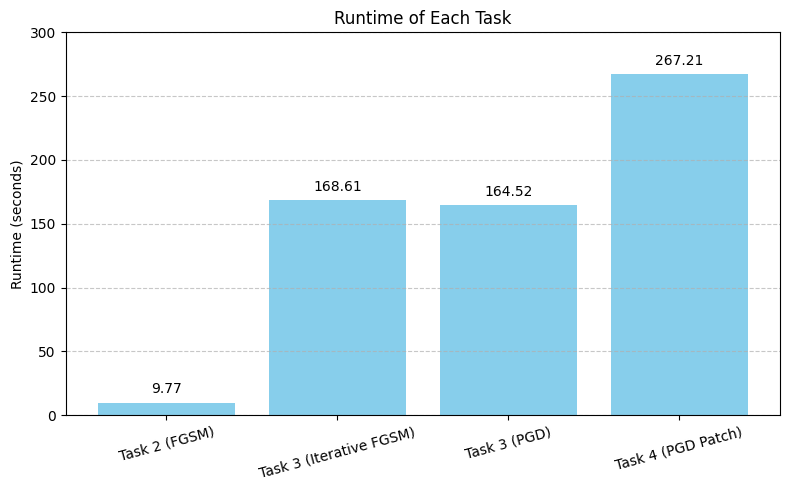

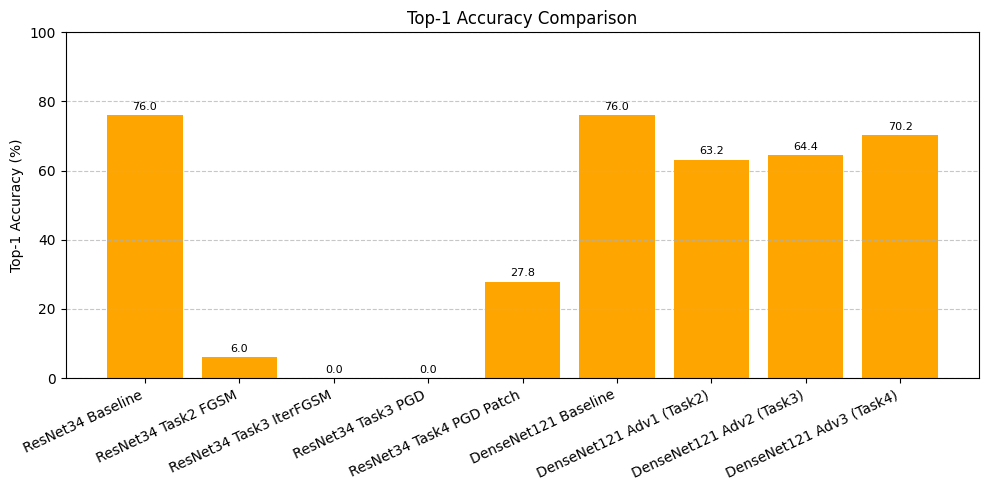

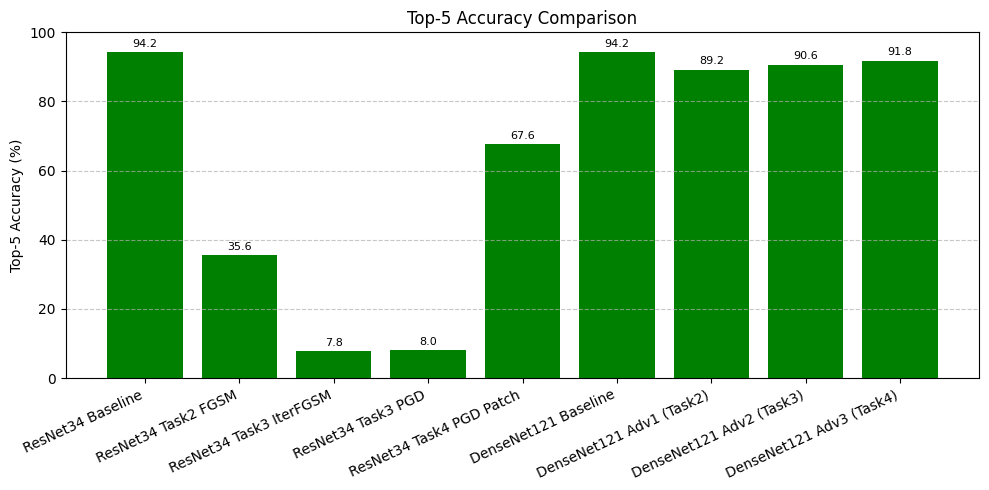

In [ ]:
import pandas as pd

# 1. Runtimes Bar Plot
runtime_data = {
    'Task': ['Task 2 (FGSM)', 'Task 3 (Iterative FGSM)', 'Task 3 (PGD)', 'Task 4 (PGD Patch)'],
    'Runtime (s)': [9.77, 168.61, 164.52, 267.21]
}
runtime_df = pd.DataFrame(runtime_data)

plt.figure(figsize=(8, 5))
bars = plt.bar(runtime_df['Task'], runtime_df['Runtime (s)'], color='skyblue')

plt.ylabel('Runtime (seconds)')
plt.title('Runtime of Each Task')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limit
plt.ylim(0, 300)

# Annotate bars with runtime values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,  # Adjust as needed
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# 2. Top-1 and Top-5 Accuracies Bar Plot
# Accuracy data
acc_data = {
    'Model & Dataset': [
        'ResNet34 Baseline', 'ResNet34 Task2 FGSM', 'ResNet34 Task3 IterFGSM', 'ResNet34 Task3 PGD', 'ResNet34 Task4 PGD Patch',
        'DenseNet121 Baseline', 'DenseNet121 Adv1 (Task2)', 'DenseNet121 Adv2 (Task3)', 'DenseNet121 Adv3 (Task4)'
    ],
    'Top-1 Accuracy (%)': [76, 6, 0, 0, 27.8, 76, 63.2, 64.4, 70.2],
    'Top-5 Accuracy (%)': [94.2, 35.6, 7.8, 8.0, 67.6, 94.2, 89.2, 90.6, 91.8]
}
acc_df = pd.DataFrame(acc_data)

# Plot Top-1 Accuracy
plt.figure(figsize=(10, 5))
bars = plt.bar(acc_df['Model & Dataset'], acc_df['Top-1 Accuracy (%)'], color='orange')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Top-1 Accuracy Comparison')
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Set y-axis limit to 100

# Add bar labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Plot Top-5 Accuracy
plt.figure(figsize=(10, 5))
bars = plt.bar(acc_df['Model & Dataset'], acc_df['Top-5 Accuracy (%)'], color='green')
plt.ylabel('Top-5 Accuracy (%)')
plt.title('Top-5 Accuracy Comparison')
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Set y-axis limit to 100

# Add bar labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()